# Fully connected feedforward network implementing a loss mask

In [ ]:
import torchmetrics.classification
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0

In [ ]:
print(cuda.get_device_name(cuda.current_device()))


NVIDIA GeForce RTX 3060 Ti


In [ ]:
import torch
import torch.nn as nn

In [ ]:
DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

### Load the Dataset

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="../data/Driams",
)

driams.loading_type = "memory"

driams

100%|██████████| 27446/27446 [00:06<00:00, 4204.05it/s]


Antibiotic:,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Cotrimoxazole,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Gentamicin,Imipenem,Levofloxacin,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Tetracycline,Tobramycin
Number resistant:,267,6120,8578,5928,618,1032,2456,677,1649,3122,2412,3629,260,1625,837,3806,204,2047,2264,371,1072,1706,2592,1315,1291,549,954,563,2021,5042,2732,486,1140,385
Number susceptible:,9321,13875,4194,1440,457,1708,15856,1272,13796,14520,3977,20191,1061,4066,4516,8729,11251,4273,10161,1349,3300,16625,15481,5889,9629,2053,2422,3269,3255,1623,15571,2305,5538,4974
Number data points:,9588,19995,12772,7368,1075,2740,18312,1949,15445,17642,6389,23820,1321,5691,5353,12535,11455,6320,12425,1720,4372,18331,18073,7204,10920,2602,3376,3832,5276,6665,18303,2791,6678,5359


### Encoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.input = nn.Linear(input_dim, hidden_dim)
        self.layer_1  = nn.Linear (hidden_dim, hidden_dim)
        self.layer_2  = nn.Linear (hidden_dim, latent_dim)
        #self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        #self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.input(x))
        h_       = self.LeakyReLU(self.layer_1(h_))
        h_       = self.LeakyReLU(self.layer_2(h_))
        
        #mean     = self.FC_mean(h_)
        #log_var  = self.FC_var(h_)  

        return h_
        return mean, log_var

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)      
        z = mean + var*epsilon
        return z
        
    def forward(self, x):
        h_    = self.LeakyReLU(self.input(x))
        h_    = self.LeakyReLU(self.layer_1(h_))
        
        output = torch.sigmoid(self.layer_2(h_))
        return output

### Combine Encoder and Decoder

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
    def forward(self, x):

        latent = self.Encoder(x)
        output = self.Decoder(latent)

        return latent, output

        
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        
        x_hat   = self.Decoder(z)
        
        return x_hat, mean, log_var

In [ ]:
len(driams.label_stats.columns)

34

In [ ]:
encoder = Encoder(input_dim=18000, hidden_dim=4096, latent_dim=2048)
decoder = Decoder(latent_dim=2048, hidden_dim = 4096, output_dim = len(driams.selected_antibiotics))

model = Model(Encoder=encoder, Decoder=decoder)
model.to(DEVICE)

Model(
  (Encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=34, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
gen = torch.Generator()
gen.manual_seed(SEED)


batch_size = 128

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# implementation is based on https://github.com/Alibaba-MIIL/ASL / https://doi.org/10.48550/arXiv.2009.14119
# Changes relate to the return value so that a mask can be applied


class AsymmetricLoss(nn.Module):
    """
    MIT License

    Copyright (c) 2020 Alibaba-MIIL
    
    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:
    
    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.
    
    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.
    """
    
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = x
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return loss


In [ ]:
from tqdm.auto import tqdm
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

print("Start training ...")
model.train()

optimizer = Adam(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_per_batch = []

criterion = AsymmetricLoss()

class_weights_negative = torch.tensor((1 - (driams.label_stats.loc["negative"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)
class_weights_positive = torch.tensor((1 - (driams.label_stats.loc["positive"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)

for epoch in tqdm(range(30)):
    overall_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):

        x = x.view(batch_size, 18000)
        x = x.to(DEVICE)
        
        
        y = y.view(batch_size, len(driams.selected_antibiotics))
        y = y.to(DEVICE)
        
        mask = torch.clone(y)
        mask[mask == 0] = 1
        mask = torch.nan_to_num(mask, 0)
        
        mask.to(DEVICE)
        y = torch.nan_to_num(y, 0)
        
        optimizer.zero_grad()

        # output, mean, log_var = model(x)
        latent, output = model(x)
        
        loss = criterion.forward(output, y)

        loss = -(loss * mask).sum()
        current_loss_value = loss.item()
        loss_per_batch.append(current_loss_value)
        
        overall_loss += current_loss_value
        
        loss.backward()
        optimizer.step()

    scheduler.step()
    with tqdm.external_write_mode():
        print(f"\tAverage Loss: {overall_loss / (batch_idx*batch_size):.6f} \tLearning rate: {scheduler.get_last_lr()[0]:.6f}")


print("Finish")

Start training ...


  0%|          | 0/30 [00:00<?, ?it/s]

	Average Loss: 0.865989 	Learning rate: 0.001000
	Average Loss: 0.741445 	Learning rate: 0.001000
	Average Loss: 0.706277 	Learning rate: 0.001000
	Average Loss: 0.671746 	Learning rate: 0.001000
	Average Loss: 0.653087 	Learning rate: 0.001000
	Average Loss: 0.629201 	Learning rate: 0.001000
	Average Loss: 0.607835 	Learning rate: 0.001000
	Average Loss: 0.583253 	Learning rate: 0.001000
	Average Loss: 0.561560 	Learning rate: 0.001000
	Average Loss: 0.549111 	Learning rate: 0.000500
	Average Loss: 0.496379 	Learning rate: 0.000500
	Average Loss: 0.477677 	Learning rate: 0.000500
	Average Loss: 0.468425 	Learning rate: 0.000500
	Average Loss: 0.445342 	Learning rate: 0.000500
	Average Loss: 0.439012 	Learning rate: 0.000500
	Average Loss: 0.432962 	Learning rate: 0.000500
	Average Loss: 0.414713 	Learning rate: 0.000500
	Average Loss: 0.394874 	Learning rate: 0.000500
	Average Loss: 0.395681 	Learning rate: 0.000500
	Average Loss: 0.365708 	Learning rate: 0.000250
	Average Loss: 0.323

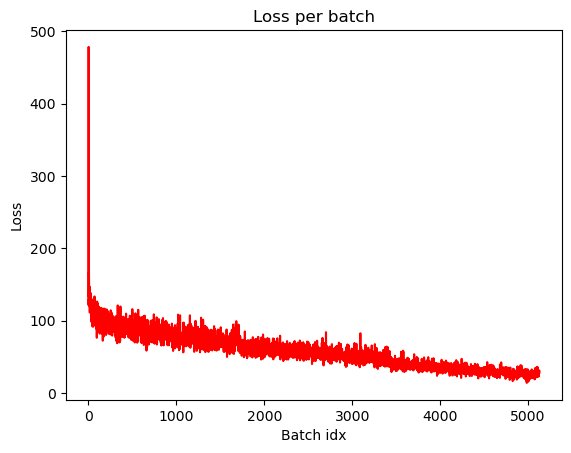

In [ ]:
import matplotlib.pyplot as plt 

plt.title("Loss per batch") 
plt.xlabel("Batch idx") 
plt.ylabel("Loss") 
plt.plot(list(range(0,len(loss_per_batch))),loss_per_batch , color ="red") 
plt.show()

In [ ]:
model.eval()

Model(
  (Encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=34, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save('./MaskedLossASL.pt')